# LoL Win-Loss Prediction Model

**Name(s)**: Minchan Kim, David Moon

**Website Link**: https://m1nce.github.io/wrmodel/

## Table of Contents

1. [Framing the Problem](#framing)
   - [Cleaning the Data](#Cleaning)
1. [Baseline Model](#Base)
1. [Final Model](#Final)
1. [Fairness Analysis](#test)
   - [Conclusion](#conclusion)


## Code

In [1]:
import pandas as pd
import numpy as np
import os
import pathlib
from pathlib import Path
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, Binarizer, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score
pd.options.plotting.backend = 'plotly'

## Importing our dataset

In [2]:
data_path = Path('data') / '2022_LoL_esports_match_data_from_OraclesElixir.csv'
df = pd.read_csv(data_path,low_memory=False)
df.head()

,gameid,datacompleteness,url,league,year,split,playoffs,date,game,patch,...,opp_csat15,golddiffat15,xpdiffat15,csdiffat15,killsat15,assistsat15,deathsat15,opp_killsat15,opp_assistsat15,opp_deathsat15
0,ESPORTSTMNT01_2690210,complete,NaN,LCKC,2022,Spring,0,2022-01-10 07:44:08,1,12.01,...,121.0,391.0,345.0,14.0,0.0,1.0,0.0,0.0,1.0,0.0
1,ESPORTSTMNT01_2690210,complete,NaN,LCKC,2022,Spring,0,2022-01-10 07:44:08,1,12.01,...,100.0,541.0,-275.0,-11.0,2.0,3.0,2.0,0.0,5.0,1.0
2,ESPORTSTMNT01_2690210,complete,NaN,LCKC,2022,Spring,0,2022-01-10 07:44:08,1,12.01,...,119.0,-475.0,153.0,1.0,0.0,3.0,0.0,3.0,3.0,2.0
3,ESPORTSTMNT01_2690210,complete,NaN,LCKC,2022,Spring,0,2022-01-10 07:44:08,1,12.01,...,149.0,-793.0,-1343.0,-34.0,2.0,1.0,2.0,3.0,3.0,0.0
4,ESPORTSTMNT01_2690210,complete,NaN,LCKC,2022,Spring,0,2022-01-10 07:44:08,1,12.01,...,21.0,443.0,-497.0,7.0,1.0,2.0,2.0,0.0,6.0,2.0


## <a id='framing'></a>1. Framing the Problem
[back to top](#top)

For our analysis, we decided to predict whether or not a team will win or lose. We decided to use a binary classification because a game only has two outcomes, a win or a loss. Because this is the way games are set up, we will consider a win to be the number "1" and a loss to be the number "0".

### <a id='Cleaning'></a>1. Cleaning the Data

While the dataset has many columns, a majority of it is unnecessary to create our baseline model. For our baseline model, we wanted to keep it relatively simple and have a theme of early game stats and see how well the model predicts the outcome.

We decided to use `'gameid'`, `'league'`, `'side'`, `'position'`, `'result'`, `'golddiffat10'`, `'firstherald'`, `'firstdragon'`, `'firstblood'`, `'xpdiffat10'`, and `'csdiffat10'` as our columns. 

Then, we got rid of any potential games that did not have an outcome due to it not being reported and then only grabbing the games that were played in the LCK region.

In [3]:
is_lck = 'LCK'
default = df.loc[:, ['gameid', 'league','position','side', 'result', 'golddiffat10','firstherald','firstdragon','firstblood','xpdiffat10','csdiffat10']]
default = default[default['position'] == 'team']
#gets rid of games that have no result
groupbyresult = default.groupby(['gameid'])[['result']].sum()
remove_games = groupbyresult[groupbyresult['result'] != 6].index
default = default[default.isin(remove_games).any(axis=1)]
default = default[default['league'] == is_lck]
default

,gameid,league,position,side,result,golddiffat10,firstherald,firstdragon,firstblood,xpdiffat10,csdiffat10
1450,ESPORTSTMNT01_2700815,LCK,team,Blue,0,281.0,1.0,0.0,1.0,404.0,6.0
1451,ESPORTSTMNT01_2700815,LCK,team,Red,1,-281.0,0.0,1.0,0.0,-404.0,-6.0
1462,ESPORTSTMNT01_2690695,LCK,team,Blue,0,-1200.0,1.0,0.0,0.0,-1277.0,-15.0
1463,ESPORTSTMNT01_2690695,LCK,team,Red,1,1200.0,0.0,1.0,1.0,1277.0,15.0
1486,ESPORTSTMNT01_2690705,LCK,team,Blue,1,152.0,1.0,1.0,1.0,-948.0,-13.0
...,...,...,...,...,...,...,...,...,...,...,...
129503,ESPORTSTMNT04_2451974,LCK,team,Red,1,578.0,0.0,1.0,0.0,757.0,29.0
129538,ESPORTSTMNT04_2472110,LCK,team,Blue,0,-2261.0,0.0,0.0,0.0,-1791.0,6.0
129539,ESPORTSTMNT04_2472110,LCK,team,Red,1,2261.0,1.0,1.0,1.0,1791.0,-6.0
129562,ESPORTSTMNT04_2472111,LCK,team,Blue,1,308.0,0.0,1.0,0.0,956.0,20.0


## <a id='Base'></a>2. Baseline Model
[back to top](#top)

For our baseline model, we wanted to predict a team's outcome (win or loss) depending on a couple of features. We used the `side`, `golddiffat10`, `firstherald`, `firstdragon`, `firstblood`, `xpdiffat10`, and `csdiffat10` columns in order to predict the outcome.

Here we first split our data from the training set and the test set with X having all the columns said above and y being the result of the game.

In [4]:
X = default.drop(columns=['gameid','league','position','result'])
y = default['result']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

We then used the ColumnTransformer class in order to implement our one-hot encoder method. The reason we use OneHotEncoder() for our `'side'` column is because we have to change red and blue into binary inputs (0's and 1's). For the remaining columns, we leave it as is because they are quantitative values.

In [5]:
preproc = ColumnTransformer(
    transformers=[
        ('categorical_col', OneHotEncoder(), ['side'])
    ],
    remainder='passthrough'
)

Lastly, we make the pipeline of the preprocessed dataframe use the DecisionTreeClassifier model with a maximum depth of 3 to help us make our model.

In [6]:
pl = Pipeline([
    ('preprocessor', preproc),
    ('clf', DecisionTreeClassifier(max_depth=3)) 
])

We then fit our training data with our training model

In [7]:
pl.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical_col',
                                                  OneHotEncoder(),
                                                  ['side'])])),
                ('clf', DecisionTreeClassifier(max_depth=3))])

We can then get the accuracy score of our training data to get around 0.70.

In [8]:
pl.score(X_train, y_train)

0.7001338688085676

Lastly, we test our model on new, unseen data, which is our X_test and y_test to get an accuracy score of about 0.68.

In [9]:
pl.score(X_test, y_test)

0.6631016042780749

We can make a confusion matrix to help us visualize our findings.

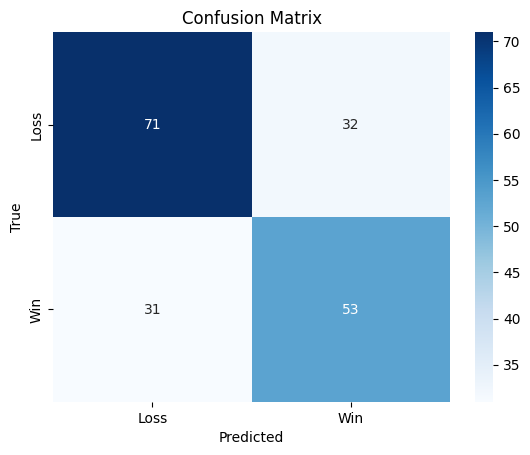

In [10]:
conf_matrix = confusion_matrix(y_test, pl.predict(X_test))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Loss', 'Win'],
            yticklabels=['Loss', 'Win'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## <a id='Final'></a>3. Final Model
[back to top](#top)

For our final model, we wanted to predict a team's outcome based on several new features like `'team kpm'`, `'barons'`, `'dpm'`, `'earned gpm'`, `'inhibitors'`, `'elders'`, `'dragons'`, and `'towers'` for our qualitative features. For our nominal features, we included `'firsttothreetowers'` ('1' indicating the team was the first to destroy three towers, and '0' otherwise) and `'side'` columns. We decided to create a totally new model and ditch the old features in our baseline model (aside from the `'side'` column) because we feel like these columns are more representative of predicting a teams' outcome as these features appear later into the game and have a more crucial impact in comparison to a feature such as getting the first dragon or rift herald in our base model.

In [11]:
final_df = df[(df['position'] == 'team') & (df['league'] == 'LCK')]
final_df = final_df[['result', 'side', 'team kpm', 'barons', 'firsttothreetowers', 'dpm', 'earned gpm', 'inhibitors', 'elders', 'dragons', 'towers']]
final_df.head()

,result,side,team kpm,barons,firsttothreetowers,dpm,earned gpm,inhibitors,elders,dragons,towers
1450,0,Blue,0.1367,0.0,1.0,1367.7813,1092.7927,0.0,0.0,1.0,8.0
1451,1,Red,0.3827,2.0,0.0,1614.6970,1200.0000,2.0,0.0,4.0,9.0
1462,0,Blue,0.2029,1.0,0.0,1935.4783,1106.7246,0.0,0.0,0.0,3.0
1463,1,Red,0.4348,1.0,1.0,1670.0290,1294.4928,1.0,0.0,4.0,9.0
1486,1,Blue,0.3224,1.0,1.0,1997.1429,1136.6950,1.0,1.0,5.0,7.0


Similarly to our baseline model, we first split our data from the training set and the test set with X having all the columns said above and y being the result of the game again but make sure to use the same X rows and y results as our baseline model (which is why we used 'random_state=1')

In [12]:
X = final_df.drop(columns='result')
y = final_df['result']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

Then, we used the ColumnTransformer class in order to implement our One-Hot Encoder, Binarizer, and StandardScaler methods to our features. Again, the reason we use OneHotEncoder() for our `'side'` column is because we have to change red and blue into binary inputs (0's and 1's). For the Binarizer, we used the `'towers'` column and had a threshold of 4 because 5 towers is the minimum amount of towers to win a match. For the rest of the quantitative columns, we used the StandardScaler method to allow for easier understanding.

In [13]:
preproc = ColumnTransformer(
    transformers=[
        ('5towers', Binarizer(threshold=4), ['towers']),
        ('categorical_col', OneHotEncoder(), ['side']),
        ('stdscaler', StandardScaler(), ['team kpm', 'dpm', 'earned gpm'])
    ],
    remainder='passthrough'
)

After preprocessing all of our data columns, we can fit it into a DecisionTreeClassifier model.

In [14]:
pl = Pipeline([
    ('preprocessor', preproc),
    ('clf', DecisionTreeClassifier(max_depth=3))
])

Then, we can fit our training data into the pipeline above.

In [15]:
pl.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('5towers',
                                                  Binarizer(threshold=4),
                                                  ['towers']),
                                                 ('categorical_col',
                                                  OneHotEncoder(), ['side']),
                                                 ('stdscaler', StandardScaler(),
                                                  ['team kpm', 'dpm',
                                                   'earned gpm'])])),
                ('clf', DecisionTreeClassifier(max_depth=3))])

We can then find the accuracy of the training data using the .score method.

In [16]:
pl.score(X_train, y_train)

0.9692101740294511

Lastly, we find the accuracy of the test data using the same method

In [17]:
pl.score(X_test, y_test)

0.9625668449197861

We created a confusion matrix to help visualize our model predictions.

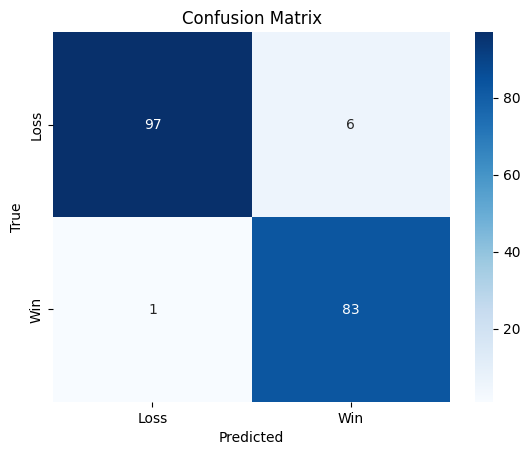

In [18]:
conf_matrix = confusion_matrix(y_test, pl.predict(X_test))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Loss', 'Win'],
            yticklabels=['Loss', 'Win'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

To find the best possible hyperparameters for our model, we decided to look for the best combination of criterions, max_depth per tree, the minimum samples to split, and the minimum samples for each split. In our param_grid dictionary, you can see the different values for every hyperparameter we tested.

In [19]:
param_grid = {
    'clf__criterion': ['gini', 'entropy'],
    'clf__max_depth': [None, 10, 20, 30],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 2, 4]
}

We then created a grid search on our training data to find the most optimal hyperparameters for our model by calculating which combination gives us the highest accuracy score.

In [20]:
grid_search = GridSearchCV(pl, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('5towers',
                                                                         Binarizer(threshold=4),
                                                                         ['towers']),
                                                                        ('categorical_col',
                                                                         OneHotEncoder(),
                                                                         ['side']),
                                                                        ('stdscaler',
                                                                         StandardScaler(),
                                                                         ['team '
                                                  

We then save the best parameters and the best model to use.

In [21]:
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

Here we show the best hyperparameters which are 'gini' for the criterion, maxmimum depth length per tree being none, a minimum sample of 4 leaves, and a minimum sample split of 5 for our hyperparameters.

In [22]:
best_params

{'clf__criterion': 'gini',
 'clf__max_depth': None,
 'clf__min_samples_leaf': 4,
 'clf__min_samples_split': 5}

We then test the model (with the most optimal hyperparameters) with our training data.

In [23]:
best_model.score(X_train, y_train)

0.9825970548862115

Lastly, we test the model again with our testing data and find the accuracy score.

In [24]:
best_model.score(X_test, y_test)

0.9679144385026738

We also implemented a confusion matrix to help visualize our results with using the model.

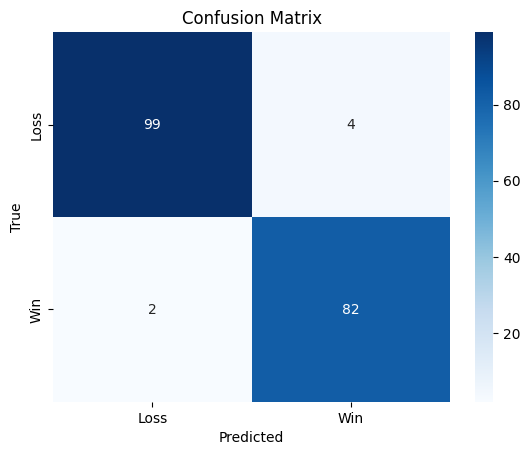

In [25]:
conf_matrix = confusion_matrix(y_test, best_model.predict(X_test))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Loss', 'Win'],
            yticklabels=['Loss', 'Win'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## <a id='test'></a> Fairness Analysis
[back to top](#top)

***Question:*** Does playing on the Blue side contain different predictions from playing on the Red side? 


**Null Hypothesis**: Our model is fair. Its accuracy for the Blue and Red side are roughly the same, and any differences are due to random chance.

**Alternative Hypothesis**: Our model is unfair. The Blue side’s accuracy is different from the Red side’s accuracy.

**Test Statistic**: Total Variation Distance between the accuracy of Red side and Blue side.

**Significance Level**: We decided to use a significance of 5% or alpha = 0.05

**Observed Statistic**: 0.0217

In [26]:
# Training accuracy
best_model.score(X_train, y_train)

0.9825970548862115

In [27]:
# Testing accuracy
best_model.score(X_test, y_test)

0.9679144385026738

We did permutation testing by shuffling the sides 1,000 times and observing if the accuracy would be different compared to the observed statistic.

In [28]:
y_pred_original = best_model.predict(X_test)

accuracy_original_Blue = accuracy_score(y_test[X_test['side'] == 'Blue'], y_pred_original[X_test['side'] == 'Blue'])
accuracy_original_Red = accuracy_score(y_test[X_test['side'] == 'Red'], y_pred_original[X_test['side'] == 'Red'])

accuracy_permutations = []

for _ in range(1000):
    shuffled_side = np.random.permutation(X_test['side'])

    accuracy_Blue = accuracy_score(y_test[X_test['side'] == 'Blue'], y_pred_original[X_test['side'] == 'Blue'])
    accuracy_Red = accuracy_score(y_test[X_test['side'] == 'Red'], y_pred_original[X_test['side'] == 'Red'])

    accuracy_diff = accuracy_Blue - accuracy_Red
    accuracy_permutations.append(accuracy_diff)

observed_diff = accuracy_original_Blue - accuracy_original_Red

p_value = (np.abs(accuracy_permutations) >= np.abs(observed_diff)).mean()

In [29]:
p_value

1.0

### <a id='conclusion'></a> Conclusion

Based on our test statistics and a p-value of 1.0, the difference in accuracy across the two groups seems significant.

Therefore, we fail to reject our null hypothesis which states that the accuracy between the Blue and Red side are the same.